In [1]:
import json

import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import (Conv2D, SeparableConv2D, DepthwiseConv2D, BatchNormalization, MaxPooling2D, SpatialDropout2D,
                          LocallyConnected2D, Dense, Flatten, Dropout, Add)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2023-01-04 10:21:44.970846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 10:21:45.808760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-04 10:21:45.808853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-04 10:21:45.808863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
count_map = {}

def generate_dense_blocks(features, num_blocks, input_layer, name_template="dense"):
    global count_map
    _l = input_layer
    for i in range(num_blocks):
        _l = BatchNormalization()(_l)
        count_to_use = count_map.get(name_template, 1)
        _l = Dense(features, activation='relu', name=f"{name_template}_{count_to_use}")(_l)
        count_map[name_template] = count_to_use + 1
        _l = Dropout(0.25)(_l)
    return _l

In [3]:
# Build the model
count_map = {}
activation = 'relu'
input_shape = 256
kernel = 3
pool = 2
padding = 'same'

dropout = 0.25

inputs = keras.Input(shape=input_shape)
features = 128
a = generate_dense_blocks(64, 3, inputs)
a = Dropout(0.25)(a)
a = Dropout(0.25)(a)
outputs = Dense(10, name='output', activation='softmax')(a)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()
model.save('model.h5')

2023-01-03 16:59:19.050251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 16:59:19.086137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 16:59:19.086339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 16:59:19.086789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                4160  

In [3]:
# Build the model
count_map = {}
activation = 'relu'
input_shape = 256
kernel = 3
pool = 2
padding = 'same'

dropout = 0.25

inputs = keras.Input(shape=input_shape)
features = 128
a = generate_dense_blocks(features, 1, inputs, name_template='a')
a1 = generate_dense_blocks(features, 1, a, name_template='a1')
a2 = generate_dense_blocks(features, 1, a, name_template='a2')
a = Add(name='sum_a')([a1,a2, a])
b = generate_dense_blocks(features, 1, inputs, name_template='b')
b1 = generate_dense_blocks(features, 2, b, name_template='b1')
b2 = generate_dense_blocks(features, 2, b, name_template='b2')
b = Add(name='sum_b')([b1, b2])
b = generate_dense_blocks(features, 2, b, name_template='b')
# c = generate_dense_blocks(features, 3, inputs, name_template='c')

a = Add(name='sum_ab')([a, b])

d = generate_dense_blocks(features, 2, a, name_template='d')
e = generate_dense_blocks(features, 3, a, name_template='e')
# e1 = generate_dense_blocks(features, 2, e, name_template='e1')
e1 = generate_dense_blocks(features, 2, e, name_template='e1')
e2 = Add(name="sum_b2_e")([e, b2])
e2 = generate_dense_blocks(features, 2, e2, name_template='e2')
# f = generate_dense_blocks(features,4, a, name_template='f')
# e = Add(name='sum_e')([e1,e2])
g = Add(name='sum_d_e')([d, e1, e2])

y = Dropout(dropout, name='dropout_out')(g)
outputs = Dense(10, name='output', activation='softmax')(y)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

2023-01-04 10:21:54.705386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:21:54.765119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:21:54.765347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:21:54.765755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 256)         1024        ['input_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 b_1 (Dense)                    (None, 128)          32896       ['batch_normalization_3[0][0]']  
                                                                                                  
 dropout_3 (Dropout)            (None, 128)          0           ['b_1[0][0]']                

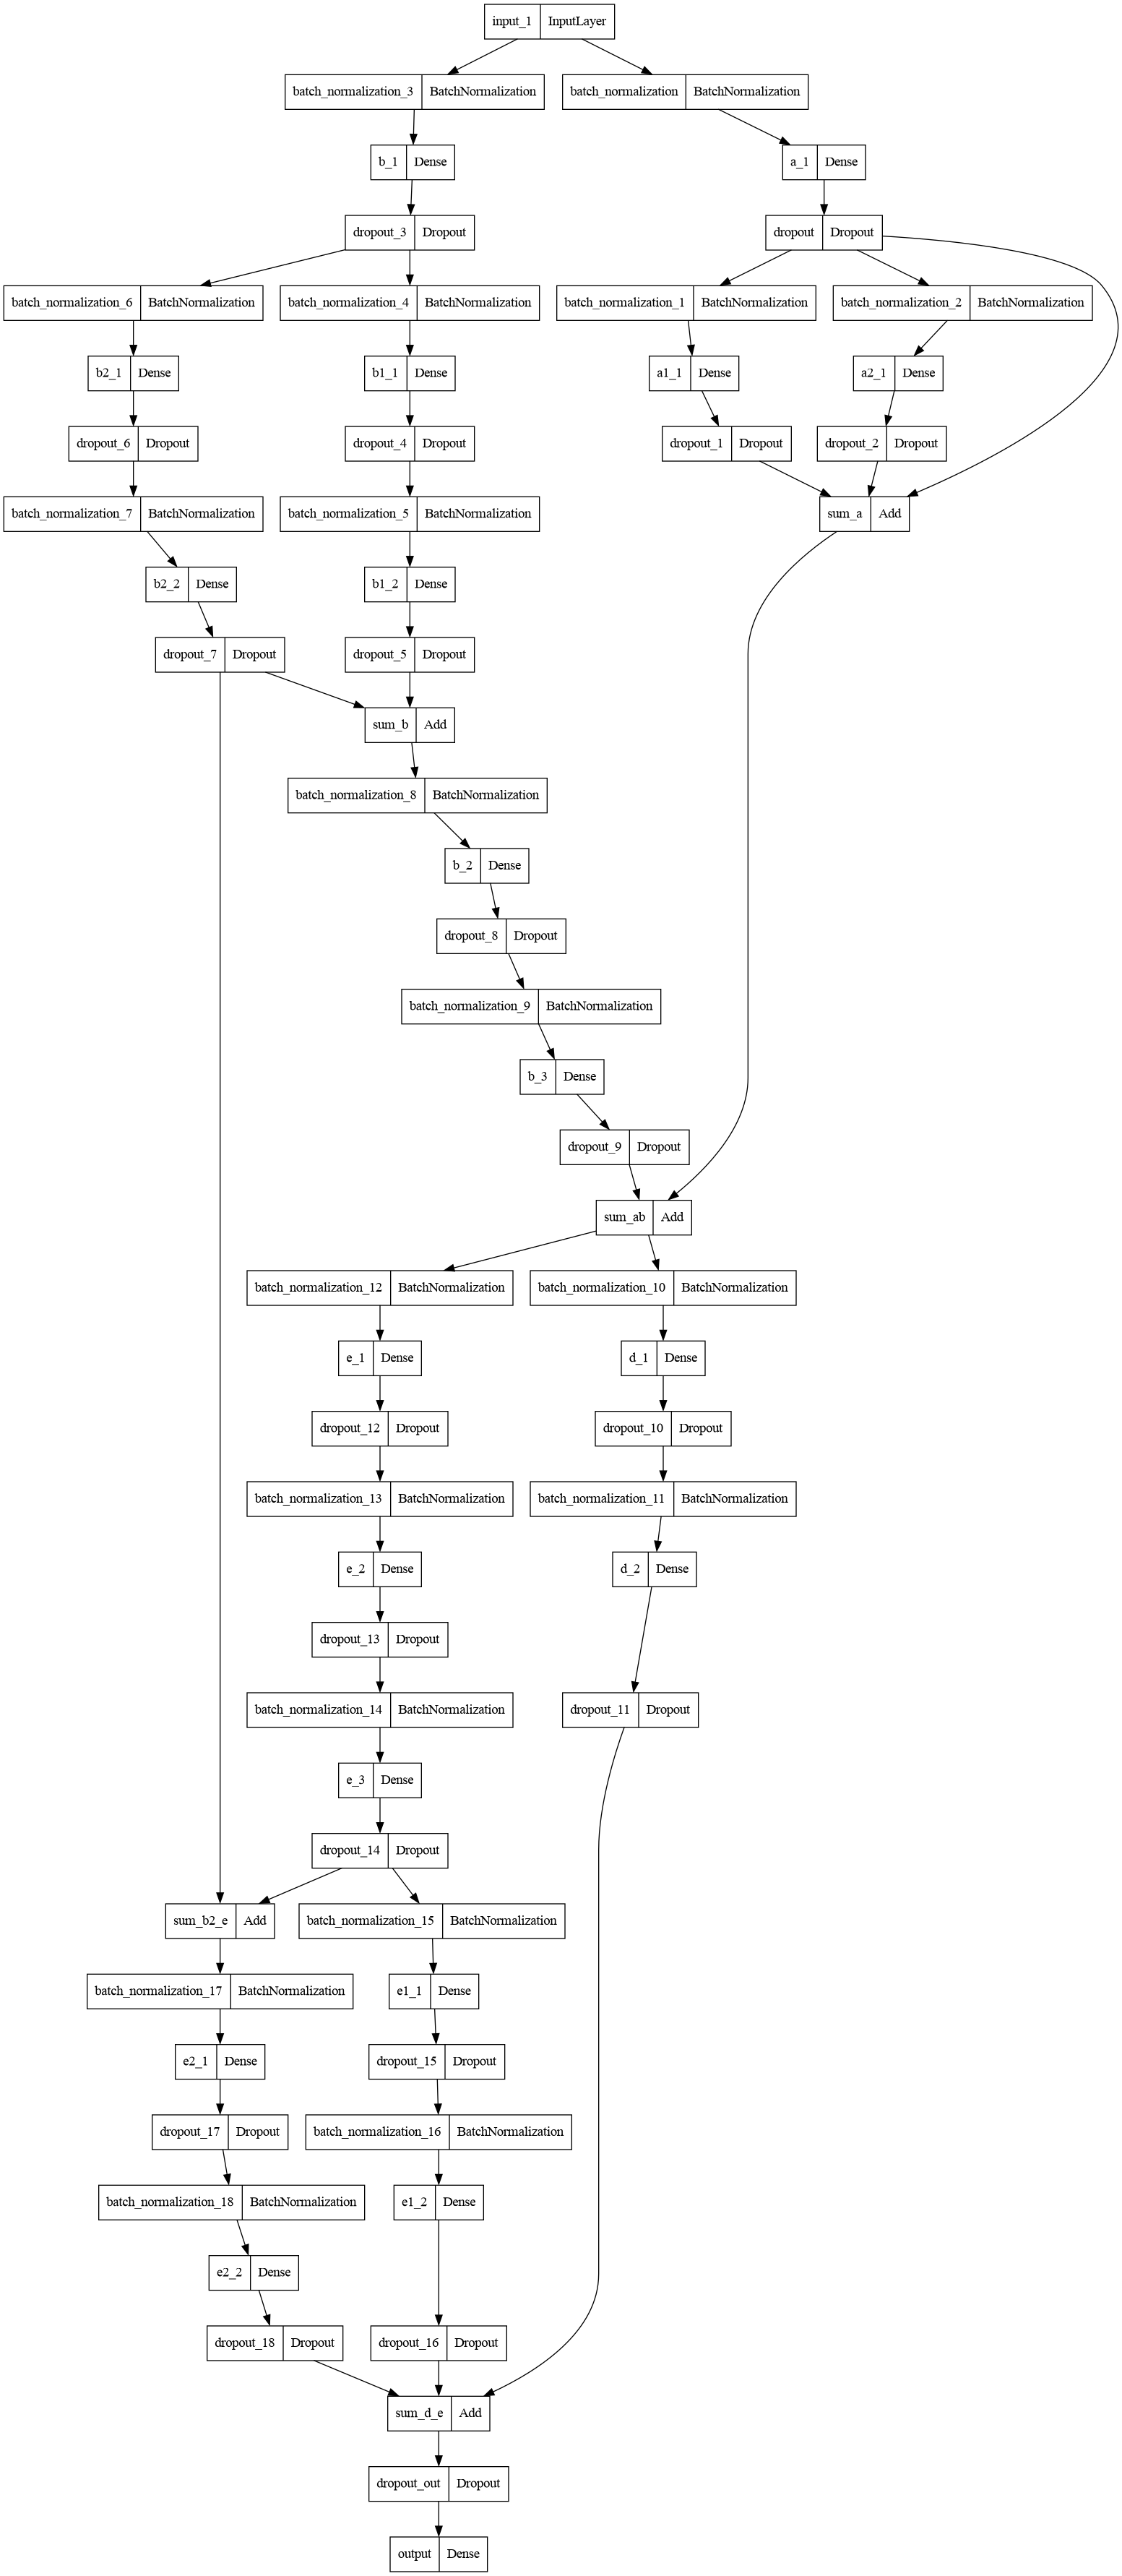

In [4]:
from keras.utils import plot_model

plot_model(model, show_shapes=False, show_dtype=False, show_layer_activations=False, show_layer_names=True)

In [5]:
model.save("model.h5")